In [1]:
import pandas as pd
from api import JolpicaF1API
from quali_plot_utils import plotQualiDrivers, plotQualiConstructors
from race_plot_utils import plotLapTimesBoxplot, plotMeanLapTimes, plotStdDevLapTimes
from utils import getConstructorColours, convertLapTimeToMs, convertToTimeFormat

In [2]:
api = JolpicaF1API()

In [3]:
constructorColors = getConstructorColours()

# Qualifying Analysis

In [4]:
qualiResults = api.getQualifyingResults('2024', 1)
qualiResults = qualiResults['MRData']['RaceTable']['Races']
qualiResults = qualiResults[0]['QualifyingResults']

qualiDf = pd.json_normalize(qualiResults, sep='_')

sessionList = ["Q1", "Q2", "Q3"]

for session in sessionList:
    qualiDf[f'{session}Ms'] = qualiDf[session].apply(convertLapTimeToMs)

sessionMsColumns = [f'{s}Ms' for s in sessionList]

if sessionMsColumns:
    qualiDf['fastestLapMs'] = qualiDf[sessionMsColumns].min(axis=1, skipna=True)
    qualiDf['fastestLap'] = qualiDf['fastestLapMs']

qualiDf['timeDiff'] = (qualiDf['fastestLapMs'] - qualiDf['fastestLapMs'].min()) / 6000
qualiDf = qualiDf.sort_values(by='timeDiff')
qualiDf['color'] = qualiDf['Constructor_name'].map(constructorColors)

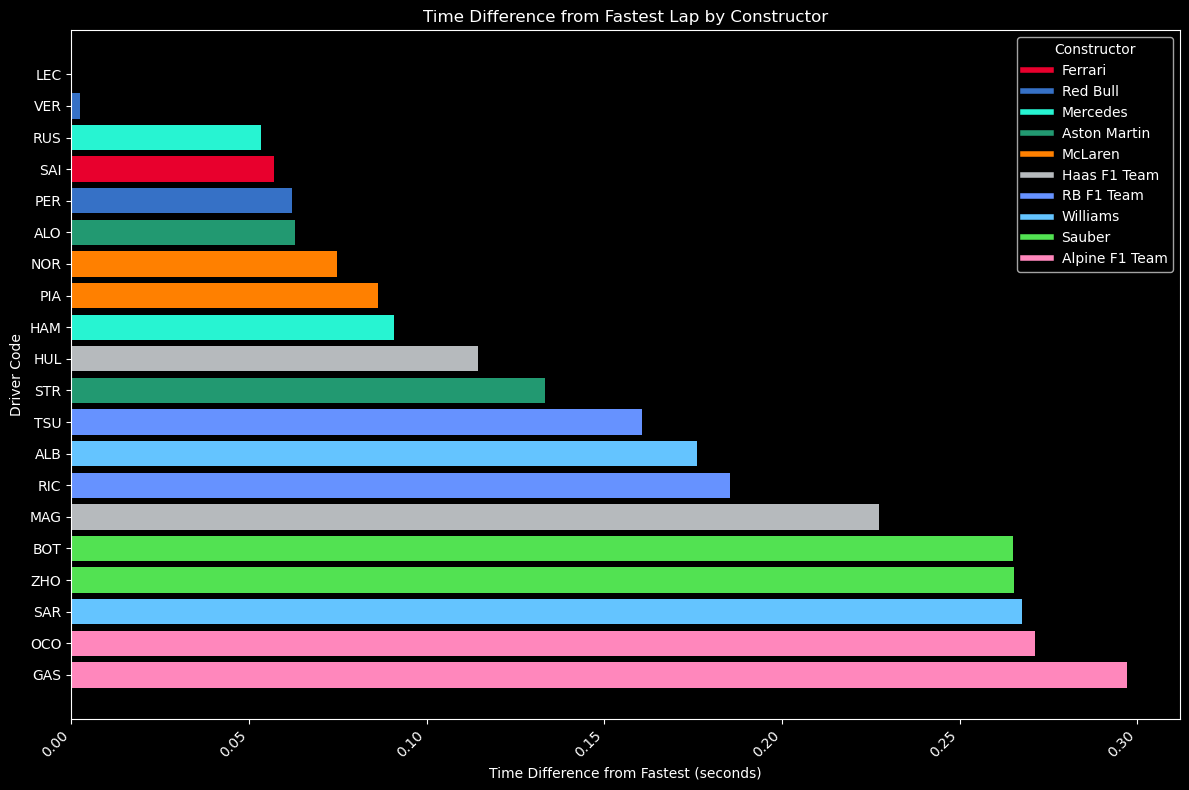

In [5]:
plotQualiDrivers(qualiDf)

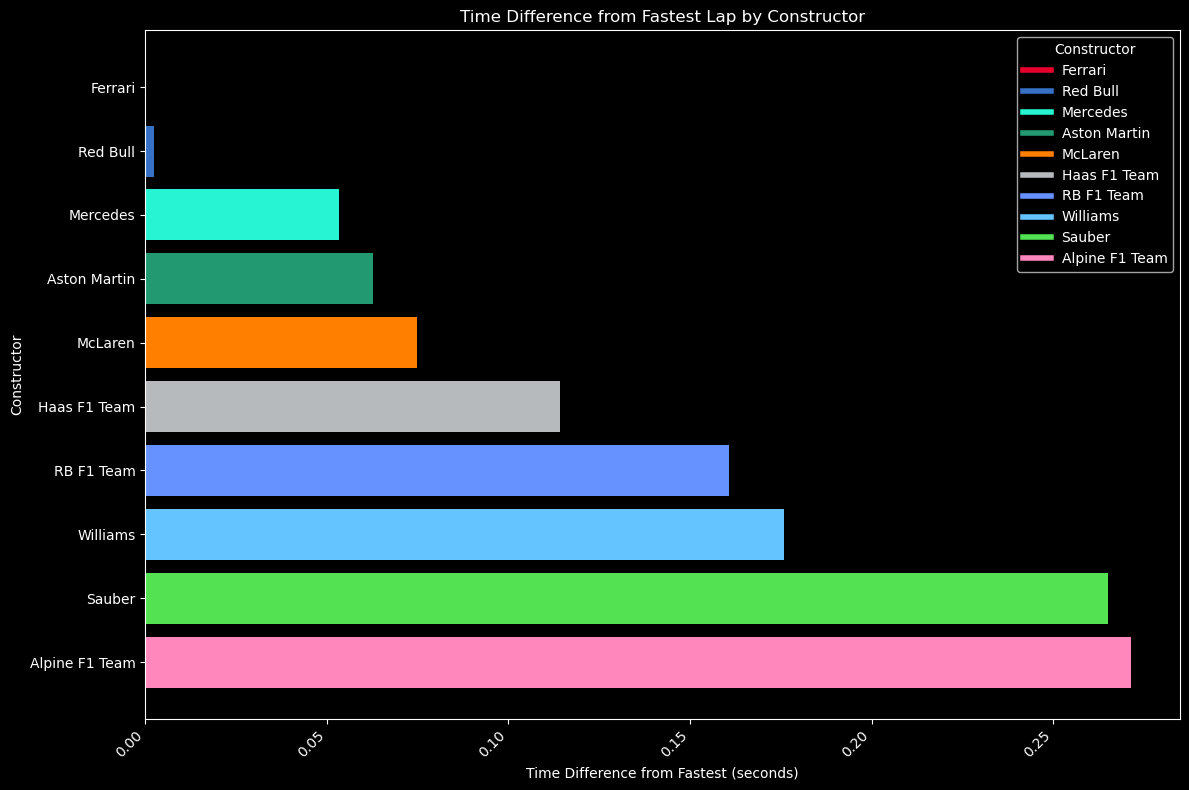

In [6]:
plotQualiConstructors(qualiDf)

# Race Analysis

In [7]:
raceResults = api.getLaps('2024', 1)
raceLaps = raceResults['MRData']['RaceTable']['Races'][0]['Laps']

In [8]:
lapTimingsDf = pd.json_normalize(raceLaps, record_path='Timings', meta=['number'])
lapTimingsDf['timeMs'] = lapTimingsDf['time'].apply(convertLapTimeToMs)
lapTimingsDf['timeMinutes'] = lapTimingsDf['timeMs'] / 60000

In [9]:
driverStandings = api.getDrivers('2024', 1)
driverData = driverStandings['MRData']['StandingsTable']['StandingsLists'][0]
driverDf = pd.json_normalize(driverData, record_path='DriverStandings')

In [10]:
driverInfoDf = driverDf[['Driver.driverId', 'Driver.permanentNumber', 'Driver.code', 
                        'Driver.givenName', 'Driver.familyName', 'Constructors']]
driverInfoDf.columns = ['driverId', 'number', 'code', 'firstName', 'lastName', 'constructors']
driverInfoDf['constructor'] = driverInfoDf['constructors'].apply(
    lambda x: x[0]['name'] if x else None
)
driverInfoDf = driverInfoDf[['driverId', 'number', 'code', 'firstName', 'lastName', 'constructor']]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12624\3943629290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driverInfoDf['constructor'] = driverInfoDf['constructors'].apply(


In [11]:
mergedRaceDf = pd.merge(lapTimingsDf, driverInfoDf, on='driverId', how='right')
mergedRaceDf = mergedRaceDf.rename(columns={'number_x': 'lap', 'number_y': 'driverNumber'})

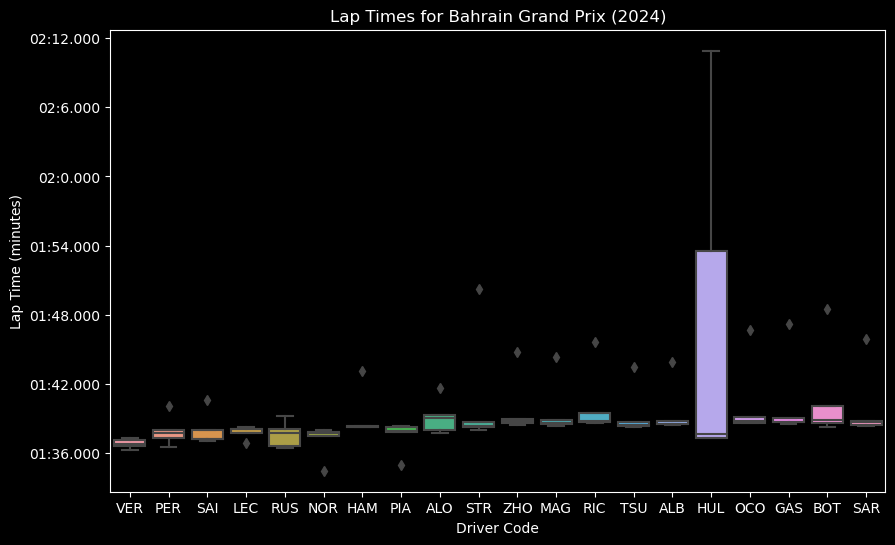

In [12]:
plotLapTimesBoxplot(mergedRaceDf)

In [13]:
pitStopData = api.getPitstops('2024', 1)
pitStops = pitStopData['MRData']['RaceTable']['Races'][0]['PitStops']
pitStopDf = pd.json_normalize(pitStops, sep=',')

In [14]:
mergedWithPitstops = pd.merge(mergedRaceDf, pitStopDf, on=['driverId', 'lap'], how='left', indicator=True)
mergedWithPitstops = mergedWithPitstops.rename(columns={'time_x': 'lapTime', 'time_y': 'pitStopTime'})

In [15]:
adjustedLapTimes = mergedWithPitstops.copy()
adjustedLapTimes['timeMs'] = pd.to_numeric(adjustedLapTimes['timeMs'], errors='coerce')
adjustedLapTimes['duration'] = pd.to_numeric(adjustedLapTimes['duration'], errors='coerce')

In [16]:
pitStopMask = adjustedLapTimes['_merge'] == 'both'
adjustedLapTimes.loc[pitStopMask, 'halfDuration'] = adjustedLapTimes.loc[pitStopMask, 'duration'] * 1000 / 2

In [17]:
nextLapAdjustments = adjustedLapTimes[pitStopMask].copy()
nextLapAdjustments['lap'] = nextLapAdjustments['lap'].astype(int) + 1
nextLapAdjustments = nextLapAdjustments[['driverId', 'lap', 'halfDuration']]

In [18]:
allAdjustments = pd.concat([
    adjustedLapTimes[pitStopMask][['driverId', 'lap', 'halfDuration']],
    nextLapAdjustments
])

adjustedLapTimes = pd.merge(
    adjustedLapTimes,
    allAdjustments,
    on=['driverId', 'lap'],
    how='left',
    suffixes=('', 'Adjust')
)

In [19]:
adjustedLapTimes['halfDurationAdjust'] = pd.to_numeric(
    adjustedLapTimes['halfDurationAdjust'], 
    errors='coerce'
).fillna(0)

adjustedLapTimes['timeMs'] = adjustedLapTimes['timeMs'] - adjustedLapTimes['halfDurationAdjust']
adjustedLapTimes['timeMinutes'] = adjustedLapTimes['timeMs'] / 60000
adjustedLapTimes = adjustedLapTimes.drop(columns=['halfDuration', 'halfDurationAdjust'])

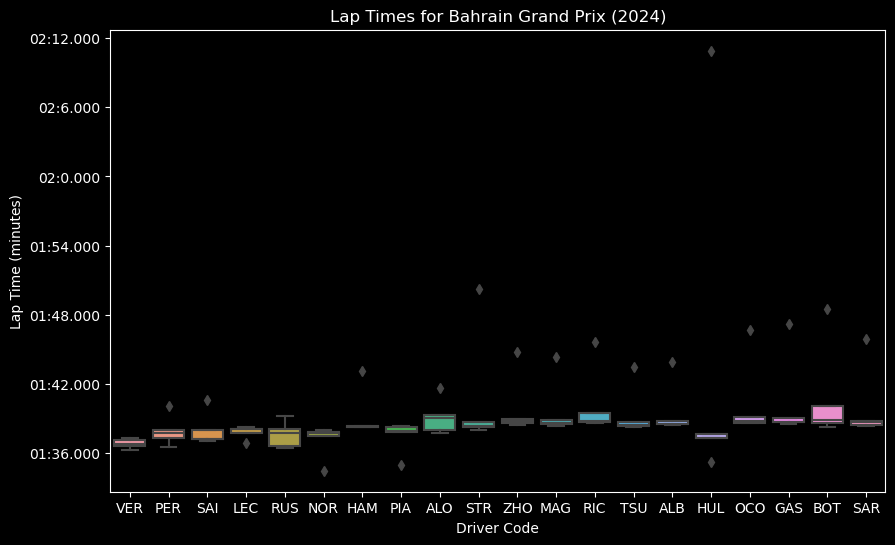

In [20]:
plotLapTimesBoxplot(adjustedLapTimes)

In [21]:
meanLapTimeMs = mergedRaceDf['timeMs'].mean()
stdLapTimeMs = mergedRaceDf['timeMs'].std()
meanLapTime = convertToTimeFormat(meanLapTimeMs)
stdLapTime = convertToTimeFormat(stdLapTimeMs)

In [22]:
meanLapTimeMsNoPitstops = adjustedLapTimes['timeMs'].mean()
stdLapTimeMsNoPitstops = adjustedLapTimes['timeMs'].std()
meanLapTimeNoPitstops = convertToTimeFormat(meanLapTimeMsNoPitstops)
stdLapTimeNoPitstops = convertToTimeFormat(stdLapTimeMsNoPitstops)

In [23]:
stats = mergedRaceDf.groupby(['driverId', 'firstName', 'lastName']).agg(
    meanTimeMs=('timeMs', 'mean'),
    stdTimeMs=('timeMs', 'std')
).reset_index()
stats['meanTime'] = stats['meanTimeMs'].apply(convertToTimeFormat)
stats['stdTime'] = stats['stdTimeMs'].apply(convertToTimeFormat)

In [24]:
stats_subset = stats[['firstName', 'lastName', 'meanTime', 'stdTime']]
stats_subset.sort_values("stdTime")

,firstName,lastName,meanTime,stdTime
8,Max,Verstappen,1:36.830,0:00.402
7,Charles,Leclerc,1:37.815,0:00.565
14,George,Russell,1:37.624,0:01.149
11,Sergio,Pérez,1:37.931,0:01.312
12,Oscar,Piastri,1:37.475,0:01.411
9,Lando,Norris,1:37.103,0:01.482
15,Carlos,Sainz,1:38.046,0:01.485
1,Fernando,Alonso,1:39.162,0:01.548
4,Lewis,Hamilton,1:39.267,0:02.155
18,Yuki,Tsunoda,1:39.447,0:02.262


In [25]:
stats = adjustedLapTimes.groupby(['driverId', 'firstName', 'lastName']).agg(
    meanTimeMs=('timeMs', 'mean'),
    stdTimeMs=('timeMs', 'std')
).reset_index()
stats['meanTime'] = stats['meanTimeMs'].apply(convertToTimeFormat)
stats['stdTime'] = stats['stdTimeMs'].apply(convertToTimeFormat)

In [26]:
stats_subset = stats[['firstName', 'lastName', 'meanTime', 'stdTime']]
stats_subset.sort_values("stdTime")

,firstName,lastName,meanTime,stdTime
8,Max,Verstappen,1:36.830,0:00.402
7,Charles,Leclerc,1:37.815,0:00.565
14,George,Russell,1:37.624,0:01.149
11,Sergio,Pérez,1:37.931,0:01.312
12,Oscar,Piastri,1:37.475,0:01.411
9,Lando,Norris,1:37.103,0:01.482
15,Carlos,Sainz,1:38.046,0:01.485
1,Fernando,Alonso,1:39.162,0:01.548
4,Lewis,Hamilton,1:39.267,0:02.155
18,Yuki,Tsunoda,1:39.447,0:02.262


In [27]:
print("\nComparison of Mean Lap Times and Standard Deviations:")
print(f"1. Unfiltered Data      - Mean Lap Time: {meanLapTime}, Standard Deviation: {stdLapTime}")
print(f"2. Pitstops Removed     - Mean Lap Time: {meanLapTimeNoPitstops}, Standard Deviation: {stdLapTimeNoPitstops}")


Comparison of Mean Lap Times and Standard Deviations:
1. Unfiltered Data      - Mean Lap Time: 1:39.501, Standard Deviation: 0:04.394
2. Pitstops Removed     - Mean Lap Time: 1:39.318, Standard Deviation: 0:04.179


In [28]:
def calculateDriverStats(df, label):
    stats = df.groupby(['driverId', 'firstName', 'lastName', 'constructor'])['timeMs'].agg(['mean', 'std']).reset_index()
    stats.columns = ['driverId', 'firstName', 'lastName', 'constructor', f'{label}Mean', f'{label}Std']
    return stats

In [29]:
baseStats = calculateDriverStats(mergedRaceDf, 'base')
adjustedStats = calculateDriverStats(adjustedLapTimes, 'adjusted')

In [30]:
combinedStats = pd.merge(baseStats, adjustedStats, on=['driverId', 'firstName', 'lastName', 'constructor'])
finalStats = combinedStats[['firstName', 'lastName', 'constructor', 'baseMean', 'baseStd', 'adjustedMean', 'adjustedStd']]

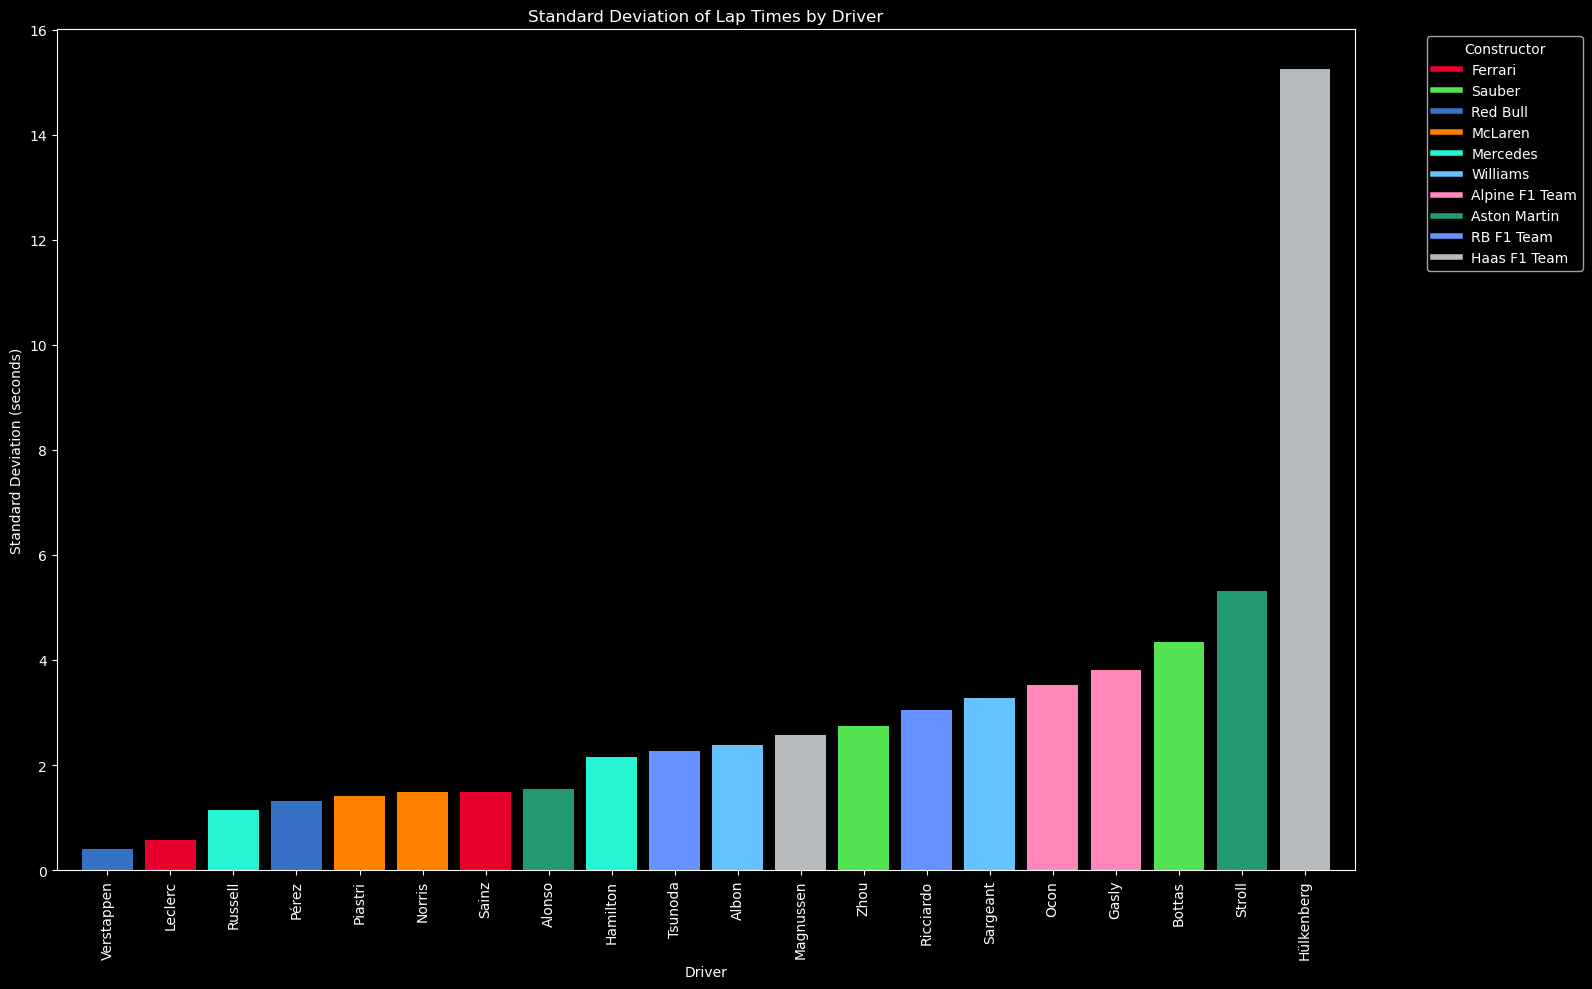

In [31]:
plotStdDevLapTimes(finalStats, constructorColors)

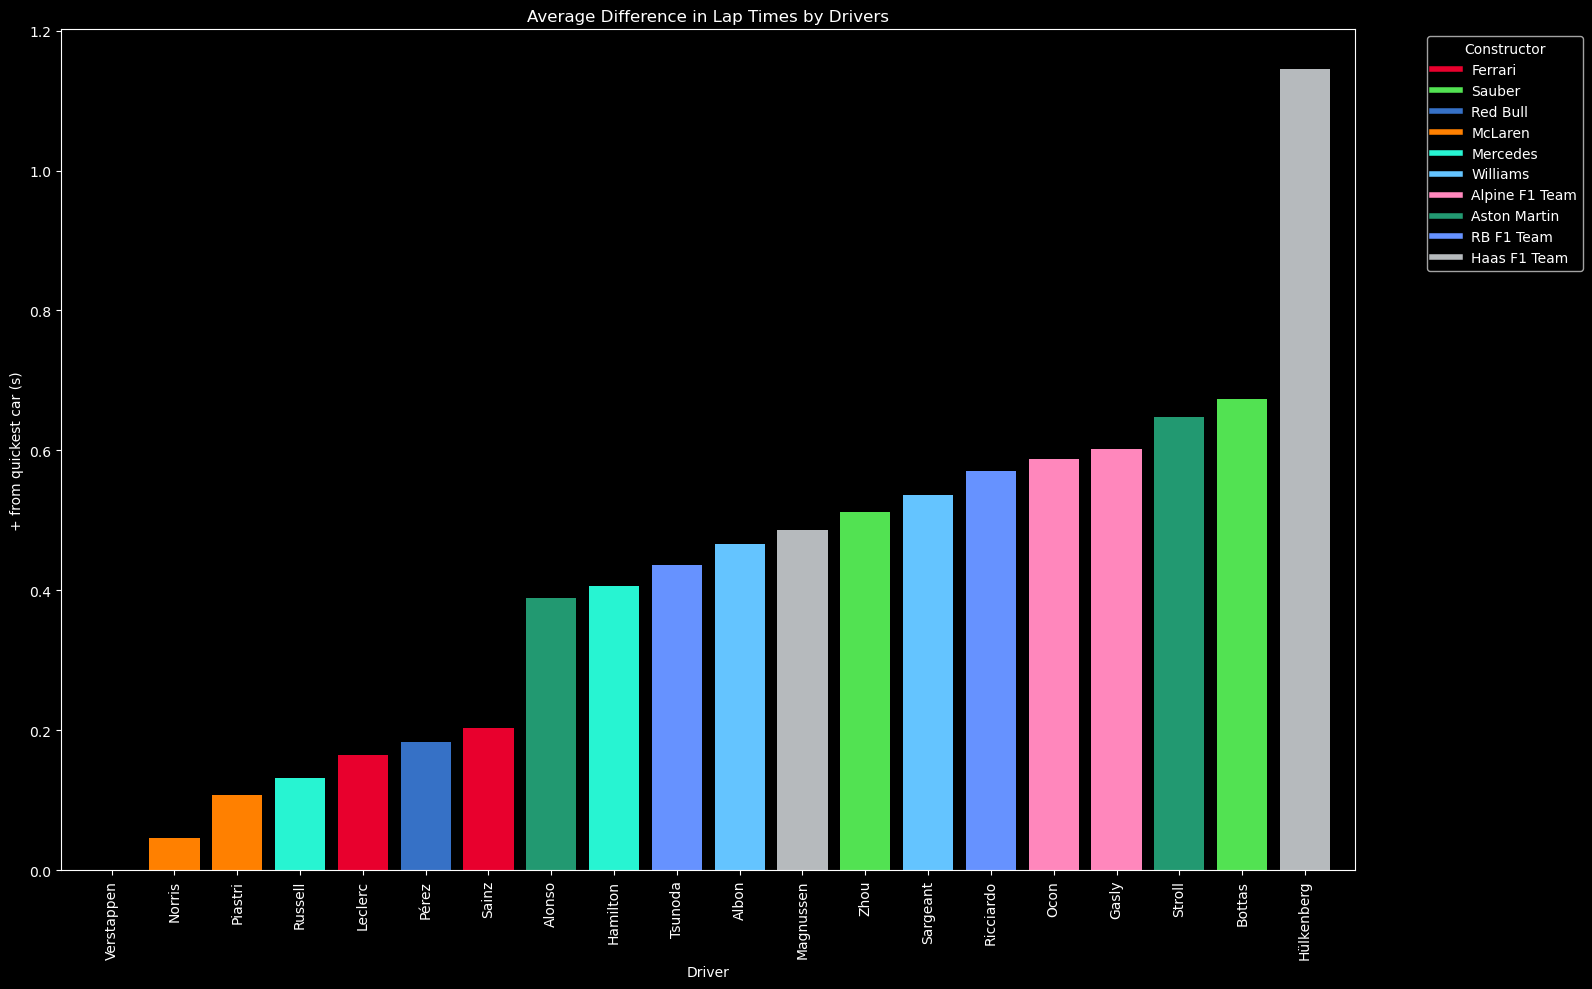

In [32]:
plotMeanLapTimes(finalStats, constructorColors)